In [1]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
# Read timeseries from csv file to Pandas dataframe...
import pandas as pd
occupation_label = "timeseries/occupation_recruitment_needs-sjuksköterska.csv"
# Deal with DateTime index...
df = pd.read_csv(occupation_label)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')
# Group dataset (i.e. resample) on month instead of days...
occupation_dataframe_month = df.resample('M').sum()

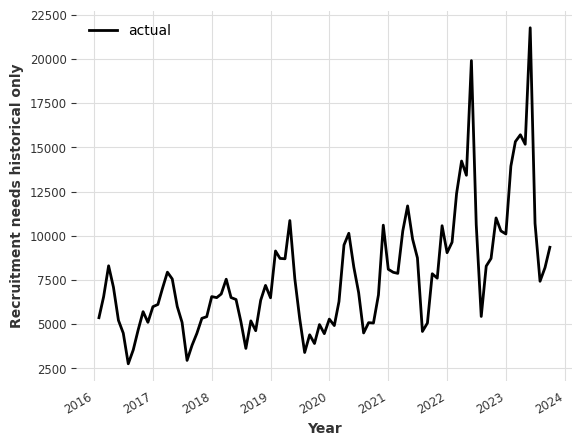

In [3]:
# Plot historical timeserie before predicting with darts...
import matplotlib.pyplot as plt
from darts import TimeSeries
series = TimeSeries.from_dataframe(occupation_dataframe_month, value_cols = 'Occurrences')
series.plot(label='actual')
plt.xlabel("Year")
plt.ylabel("Recruitment needs historical only")
plt.legend()

In [4]:
# Split dataframe into training timeseries and validation timeseries...
train, val = series.split_before(0.7)

In [5]:
# Try out different prediction models by its MAPE (i.e. Mean absolute percentage error, the lower the better)...
from darts.metrics import mape
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta, NaiveDrift, NaiveSeasonal, NaiveDrift

def eval_model(model):
    # Apply training dataset (i.e. from dataframe) to darts model...
    model.fit(train)
    #  Predict forecast and print out MAPE...
    forecast = model.predict(len(val))
    display("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


In [6]:
eval_model(ExponentialSmoothing())

'model ExponentialSmoothing() obtains MAPE: 15.67%'

In [7]:
eval_model(TBATS())

'model TBATS() obtains MAPE: 27.04%'

In [8]:
eval_model(AutoARIMA())

'model AutoARIMA() obtains MAPE: 37.01%'

In [9]:
eval_model(Theta())

'model Theta() obtains MAPE: 24.43%'

In [10]:
eval_model(NaiveSeasonal())

'model NaiveSeasonal() obtains MAPE: 37.41%'

In [11]:
eval_model(NaiveDrift())

'model NaiveDrift() obtains MAPE: 44.99%'

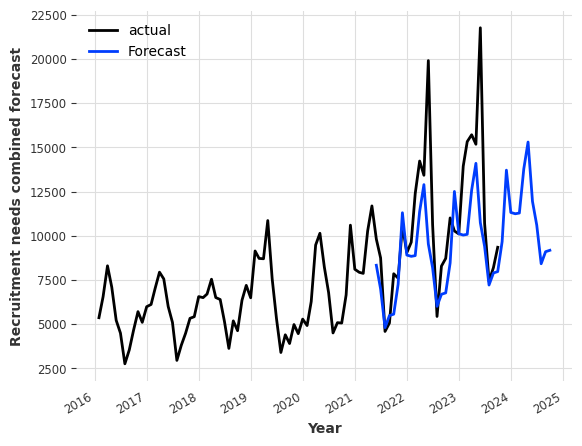

In [12]:
# Try out combination of NaiveSeasonal and NaiveDrift:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val) + 12)
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val) + 12)
combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
series.plot(label='actual')
combined_forecast.plot(label='Forecast')
plt.xlabel("Year")
plt.ylabel("Recruitment needs combined forecast")
plt.legend()

In [13]:
# Print MEAN for combination of NaiveSeasonal and NaiveDrift:
display("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)))

'Mean absolute percentage error for the combined naive drift + seasonal: 17.12%.'

In [14]:
# Calculate the best theta value for the theta model...
# Defaults to 2. If theta = 1, then the fourtheta method restricts to a simple exponential smoothing (SES).
# If theta = 0, then the fourtheta method restricts to a simple trend_mode regression.
import numpy as np
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

display(f"{best_theta} is the best value for the current timeserie")

'-0.24489795918367463 is the best value for the current timeserie'

In [15]:
# Use darts with the best theta value and predict...
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

display(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

'The MAPE is: 11.73, with theta = -0.24489795918367463.'

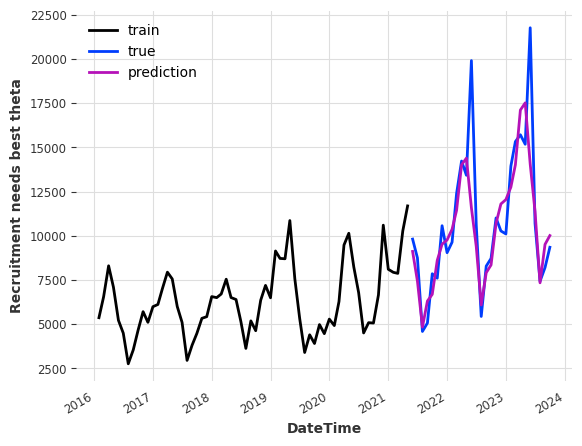

In [16]:
# Plot with prediction for historical period...
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")
plt.ylabel("Recruitment needs best theta")
plt.legend()

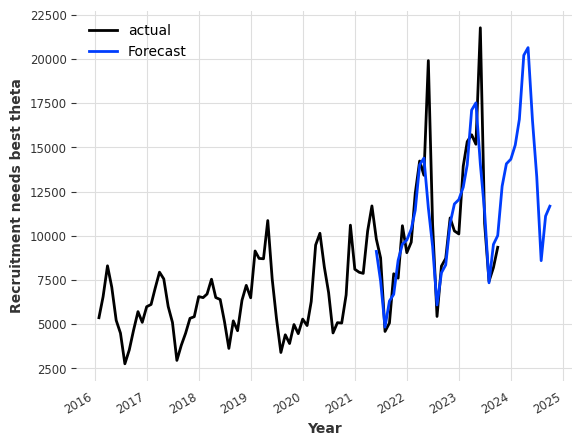

In [17]:
# Use darts with the best theta value and predict for the future...   
best_theta_model.fit( train)
pred_best_theta = best_theta_model.predict(len(val)+ 12)
series.plot(label='actual')
pred_best_theta.plot(label='Forecast')
plt.xlabel("Year")
plt.ylabel("Recruitment needs best theta")
plt.legend()

In [18]:
# Evaluate TBATS as alternative model...
tbats_model = TBATS()
tbats_model.fit(train)
pred_tbats = tbats_model.predict(len(val))

display(
    "The MAPE is: {:.2f}".format(
        mape(val, pred_tbats)
    )
)

'The MAPE is: 27.04'

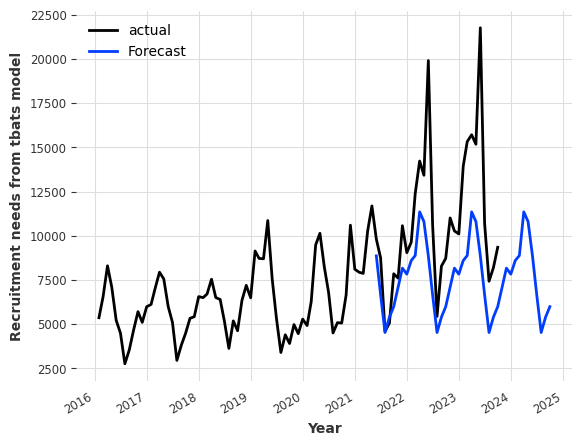

In [19]:
pred_tbats = tbats_model.predict(len(val)+ 12)
series.plot(label='actual')
pred_tbats.plot(label='Forecast')
plt.xlabel("Year")
plt.ylabel("Recruitment needs from tbats model")
plt.legend()